# Load Packages

In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
import pyunpack
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys

from rarfile import RarFile
import segmentation_models as sm
from keras_segmentation.models import segnet
from keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        

2025-12-08 22:49:42.124784: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Segmentation Models: using `keras` framework.


# Functions

In [3]:
'''
  Metric functions for evaluation - OPTIMIZED: Single forward pass for all metrics
'''

def evaluate_all_metrics(model, images, masks, num_classes=5):
    """
    Compute all metrics with a single forward pass through the model.
    Returns: dict with all metric scores
    """
    print(f"  Processing {len(images)} images...")
    
    all_predictions = []
    all_masks = []
    
    # Single forward pass for all images
    for i in range(len(images)):
        if i % 100 == 0:
            print(f"    {i}/{len(images)}")
        
        img = images[i].reshape(1, 512, 512, 3)
        reconstruction = model.predict(img, verbose=0)
        reconstruction = np.argmax(reconstruction, axis=-1).flatten()  # Convert to class indices
        
        all_predictions.append(reconstruction)
        all_masks.append(masks[i].flatten())
    
    print(f"    {len(images)}/{len(images)} - Done!")
    
    # Now compute all metrics from the predictions
    print("  Computing metrics from predictions...")
    
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'iou': [],
        'miou': []
    }
    
    for pred, mask in zip(all_predictions, all_masks):
        # Accuracy
        metrics['accuracy'].append(accuracy_score(mask, pred))
        
        # Precision
        metrics['precision'].append(precision_score(mask, pred, average='weighted', zero_division=0))
        
        # Recall
        metrics['recall'].append(recall_score(mask, pred, average='weighted', zero_division=0))
        
        # IoU (Jaccard)
        metrics['iou'].append(jaccard_score(mask, pred, average='weighted', zero_division=0))
        
        # Mean IoU (per-class IoU)
        iou_per_class = []
        for cls in range(num_classes):
            intersection = np.sum((mask == cls) & (pred == cls))
            union = np.sum((mask == cls) | (pred == cls))
            if union > 0:
                iou_per_class.append(intersection / union)
            else:
                iou_per_class.append(0)
        metrics['miou'].append(np.mean(iou_per_class))
    
    return metrics


def f1_score_from_metrics(precision, recall):
    """Compute F1 score from precision and recall"""
    prec = np.mean(precision)
    rec = np.mean(recall)
    
    if prec + rec == 0:
        return 0
    
    return 2 * (prec * rec) / (prec + rec)


# Keep old functions for backward compatibility (not used in new evaluation)
def score_eval(model, image, mask):
    if type(image) != list:   
        reconstruction = model.predict(image, verbose=0, batch_size=32)
        reconstruction = np.argmax(reconstruction, axis=-1).flatten()
        mask_flat = mask.flatten()
        return accuracy_score(mask_flat, reconstruction)
    else:
        scores = []
        for i in range(len(image)):
            img = image[i].reshape(1, 512, 512, 3)
            reconstruction = model.predict(img, verbose=0)
            reconstruction = np.argmax(reconstruction, axis=-1).flatten()
            scores.append(accuracy_score(mask[i].flatten(), reconstruction))
        return scores

def produce_mask(image):
    return np.argmax(image, axis=-1)

# Models

## Attention U-Net (5 Classes)

In [4]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    
    # Use tf.shape for dynamic batch size and K.int_shape for static dimensions
    batch_size = tf.shape(x)[0]
    target_shape = tf.stack([batch_size, shape_x[1], shape_x[2], shape_x[3]])
    upsample_psi = tf.broadcast_to(upsample_psi, shape=target_shape)
    
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model - ADAPTED FOR 5 CLASSES with Mixed Precision Support
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), num_classes=5, drop_rate = 0.25, lr=0.0001, filter_base=16):

  ## Can add pretrained weights by specifying 'trained_weights'

  # Input layer - removed fixed batch_size to allow dynamic batching
  inputs = Input(input_size)

  ## Contraction phase
  conv = convBlock2(inputs, filter_base, 3)

  conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
  conv0 = convBlock2(conv0, 2 * filter_base, 3)

  pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
  conv1 = convBlock2(pool0, 4 * filter_base, 3)

  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = convBlock2(pool1, 8 * filter_base, 3)

  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = convBlock2(pool2, 16 * filter_base, 3)

  ## Expansion phase
  up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
  merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
  conv4 = concatenate([up4, merge4])
  conv4 = convBlock2(conv4, 8 * filter_base, 3)

  up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
  merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
  conv5 = concatenate([up5, merge5])
  conv5 = convBlock2(conv5, 4 * filter_base, 3)

  up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
  merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
  conv6 = concatenate([up6, merge6])
  conv6 = convBlock2(conv6, 2 * filter_base, 3)

  up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
  merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
  conv7 = concatenate([up7, merge7])
  conv7 = concatenate([up7, conv])
  conv7 = convBlock2(conv7, 1 * filter_base, 3)

  ## Output layer - CHANGED FOR 5 CLASSES
  # Output num_classes channels with softmax activation
  out = Conv2D(num_classes, 1, padding='same', kernel_initializer='he_normal')(conv7)
  out = Activation('softmax', dtype='float32')(out)  # Force float32 for final layer (mixed precision requirement)

  model = Model(inputs, out)

  # Use sparse_categorical_crossentropy since masks are integer labels (0-4)
  model.compile(
      optimizer = adam_v2.Adam(learning_rate = lr), 
      loss = 'sparse_categorical_crossentropy',
      metrics = ['accuracy']
  )

  if trained_weights != None:
    model.load_weights(trained_weights)

  return model

In [5]:
# Print model layers and number of parameters
UNetAM(num_classes=5).summary()

2025-12-08 22:49:45.123438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 22:49:45.726668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:b1:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [6]:
# ============================================
# Load preprocessed .npy dataset
# ============================================

import glob
import numpy as np
import os

PROCESSED_ROOT = "extra-dataset-processed-5classes"

def load_npy_pairs(split="training"):
    img_dir = os.path.join(PROCESSED_ROOT, split, "images")
    mask_dir = os.path.join(PROCESSED_ROOT, split, "masks")

    img_files = sorted(glob.glob(os.path.join(img_dir, "*.npy")))
    mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))

    images = []
    masks = []

    for img_path, mask_path in zip(img_files, mask_files):
        img = np.load(img_path)    # shape: (1,512,512,3)
        mask = np.load(mask_path)  # shape: (1,512,512,1) with values 0-4

        # remove batch dimension: (1,512,512,3) → (512,512,3)
        img = img[0]
        mask = mask[0]

        images.append(img.astype("float32"))
        masks.append(mask.astype("int32"))  # Keep as integers for sparse_categorical_crossentropy

    return images, masks


# Load dataset
train_images_extra, train_masks_extra = load_npy_pairs("training")
val_images_extra, val_masks_extra = load_npy_pairs("validation")
test_images_extra, test_masks_extra = load_npy_pairs("test")

print("Loaded:")
print("  Train:", len(train_images_extra))
print("  Val:", len(val_images_extra))
print("  Test:", len(test_images_extra))

# Check mask values to ensure they are 0-4
print("\nMask value range check:")
print("  Train mask min/max:", np.min([m.min() for m in train_masks_extra]), "/", np.max([m.max() for m in train_masks_extra]))
print("  Val mask min/max:", np.min([m.min() for m in val_masks_extra]), "/", np.max([m.max() for m in val_masks_extra]))
print("  Test mask min/max:", np.min([m.min() for m in test_masks_extra]), "/", np.max([m.max() for m in test_masks_extra]))

Loaded:
  Train: 7470
  Val: 1602
  Test: 1602

Mask value range check:
  Train mask min/max: 0 / 4
  Val mask min/max: 0 / 4
  Test mask min/max: 0 / 4


In [7]:
## Train Attention U-Net (LandCover.ai, RGB, 5 classes)
EPOCHS_EXTRA = 200
BATCH_SIZE_EXTRA = 64

def make_tf_dataset(images, masks, batch_size=8, shuffle=True):
    """Optimized data pipeline for faster training"""
    # Define generator function
    def generator():
        for img, mask in zip(images, masks):
            yield img, mask

    # Use from_generator instead of from_tensor_slices
    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32), # Image format
            tf.TensorSpec(shape=(512, 512, 1), dtype=tf.int32)    # Mask format (integer labels)
        )
    )

    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(images), 1000))  # Increased buffer for better shuffling
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)  # Prefetch next batch while training current batch
    
    # Cache dataset in memory if possible (speeds up subsequent epochs)
    # Comment out if running out of RAM
    # ds = ds.cache()
    
    return ds


train_ds_extra = make_tf_dataset(train_images_extra, train_masks_extra, batch_size=BATCH_SIZE_EXTRA)
val_ds_extra = make_tf_dataset(val_images_extra, val_masks_extra, batch_size=BATCH_SIZE_EXTRA, shuffle=False)
test_ds_extra = make_tf_dataset(test_images_extra, test_masks_extra, batch_size=BATCH_SIZE_EXTRA, shuffle=False)

print(f"Training batches per epoch: {len(train_images_extra) // BATCH_SIZE_EXTRA}")
print(f"Validation batches per epoch: {len(val_images_extra) // BATCH_SIZE_EXTRA}")

Training batches per epoch: 116
Validation batches per epoch: 25


In [ ]:
# Train on LandCover.ai extra RGB dataset (5 classes)
# Attention U-Net with Mixed Precision Training

# Enable mixed precision training for faster training on RTX 4090
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled: using float16 for computation, float32 for variables")

# Create model
am_unet_extra = UNetAM(input_size=(512,512,3), num_classes=5, filter_base=16, lr=0.0005)

# Callbacks
save_am_unet_extra = ModelCheckpoint(
    'unet-attention-extra-5classes.hdf5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True
)

# Early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train
history_am_unet_extra = am_unet_extra.fit(
    train_ds_extra,
    epochs=EPOCHS_EXTRA,
    validation_data=val_ds_extra,
    callbacks=[save_am_unet_extra, early_stop, reduce_lr],
    verbose=1
)

# Save history
np.save('unet-attention-extra-5classes-history.npy', history_am_unet_extra.history)

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation accuracy: {max(history_am_unet_extra.history['val_accuracy']):.4f}")
print("="*60)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9
Mixed precision enabled: using float16 for computation, float32 for variables
Epoch 1/200


2025-12-08 20:11:18.834704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-12-08 20:11:19.652580: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-12-08 20:11:19.652598: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-12-08 20:11:19.652644: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


    117/Unknown - 80s 560ms/step - loss: 1.0091 - accuracy: 0.5779
Epoch 1: val_accuracy improved from -inf to 0.61355, saving model to unet-attention-extra-5classes.hdf5
117/117 [==============================] - 86s 614ms/step - loss: 1.0091 - accuracy: 0.5779 - val_loss: 0.9348 - val_accuracy: 0.6135 - lr: 5.0000e-04
Epoch 2/200
117/117 [==============================] - ETA: 0s - loss: 0.9413 - accuracy: 0.5921
Epoch 2: val_accuracy did not improve from 0.61355
117/117 [==============================] - 71s 572ms/step - loss: 0.9413 - accuracy: 0.5921 - val_loss: 0.9156 - val_accuracy: 0.6132 - lr: 5.0000e-04
Epoch 3/200
117/117 [==============================] - ETA: 0s - loss: 0.9411 - accuracy: 0.5941
Epoch 3: val_accuracy improved from 0.61355 to 0.63131, saving model to unet-attention-extra-5classes.hdf5
117/117 [==============================] - 70s 578ms/step - loss: 0.9411 - accuracy: 0.5941 - val_loss: 0.9023 - val_accuracy: 0.6313 - lr: 5.0000e-04
Epoch 4/200
117/117 [===

: 

In [8]:
# Evaluation - OPTIMIZED: Single forward pass per dataset
import gc

# Load Attention U-Net
print("Loading model...")
am_unet_extra_eval = UNetAM(
    trained_weights='unet-attention-extra-5classes.hdf5',
    input_size=(512, 512, 3),
    num_classes=5,
    filter_base=16,
    lr=0.0005
)

print("\n" + "="*60)
print("VALIDATION SET EVALUATION")
print("="*60)
print(f"Validation set: {len(val_images_extra)} images\n")

# Single pass to compute all metrics
val_metrics = evaluate_all_metrics(am_unet_extra_eval, val_images_extra, val_masks_extra, num_classes=5)
val_f1 = f1_score_from_metrics(val_metrics['precision'], val_metrics['recall'])
gc.collect()

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"Test set: {len(test_images_extra)} images\n")

# Single pass to compute all metrics
test_metrics = evaluate_all_metrics(am_unet_extra_eval, test_images_extra, test_masks_extra, num_classes=5)
test_f1 = f1_score_from_metrics(test_metrics['precision'], test_metrics['recall'])
gc.collect()

print("\n" + "="*60)
print("RESULTS")
print("="*60)

# Validation metrics
metrics_extra_val = {
    'classifier': ['Attention U-Net (5 classes)'],
    'accuracy':  [np.mean(val_metrics['accuracy'])],
    'precision': [np.mean(val_metrics['precision'])],
    'recall':    [np.mean(val_metrics['recall'])],
    'f1_score':  [val_f1],
    'iou':       [np.mean(val_metrics['iou'])],
    'miou':      [np.mean(val_metrics['miou'])],
    'accuracy_std':  [np.std(val_metrics['accuracy'])],
    'precision_std': [np.std(val_metrics['precision'])],
    'recall_std':    [np.std(val_metrics['recall'])],
    'iou_std':       [np.std(val_metrics['iou'])],
    'miou_std':      [np.std(val_metrics['miou'])],
}

metrics_extra_val = pd.DataFrame(metrics_extra_val)
metrics_extra_val.to_csv('metrics_extra_val_landcover_5classes.csv', index=False)
print("\nValidation Metrics:")
print(metrics_extra_val)

# Test metrics
metrics_extra_test = {
    'classifier': ['Attention U-Net (5 classes)'],
    'accuracy':  [np.mean(test_metrics['accuracy'])],
    'precision': [np.mean(test_metrics['precision'])],
    'recall':    [np.mean(test_metrics['recall'])],
    'f1_score':  [test_f1],
    'iou':       [np.mean(test_metrics['iou'])],
    'miou':      [np.mean(test_metrics['miou'])],
    'accuracy_std':  [np.std(test_metrics['accuracy'])],
    'precision_std': [np.std(test_metrics['precision'])],
    'recall_std':    [np.std(test_metrics['recall'])],
    'iou_std':       [np.std(test_metrics['iou'])],
    'miou_std':      [np.std(test_metrics['miou'])],
}

metrics_extra_test = pd.DataFrame(metrics_extra_test)
metrics_extra_test.to_csv('metrics_extra_test_landcover_5classes.csv', index=False)
print("\nTest Metrics:")
print(metrics_extra_test)

print("\n" + "="*60)
print("Evaluation complete! Results saved to CSV files.")
print("="*60)

Loading model...

VALIDATION SET EVALUATION
Validation set: 1602 images

  Processing 1602 images...
    0/1602


2025-12-08 22:13:01.967590: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-12-08 22:13:02.741818: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-12-08 22:13:02.741833: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-12-08 22:13:02.741877: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


    100/1602
    200/1602
    300/1602
    400/1602
    500/1602
    600/1602
    700/1602
    800/1602
    900/1602
    1000/1602
    1100/1602
    1200/1602
    1300/1602
    1400/1602
    1500/1602
    1600/1602
    1602/1602 - Done!
  Computing metrics from predictions...

TEST SET EVALUATION
Test set: 1602 images

  Processing 1602 images...
    0/1602
    100/1602
    200/1602
    300/1602
    400/1602
    500/1602
    600/1602
    700/1602
    800/1602
    900/1602
    1000/1602
    1100/1602
    1200/1602
    1300/1602
    1400/1602
    1500/1602
    1600/1602
    1602/1602 - Done!
  Computing metrics from predictions...

RESULTS

Validation Metrics:
                    classifier  accuracy  precision    recall  f1_score   
0  Attention U-Net (5 classes)  0.767862     0.8087  0.767862  0.787752  \

        iou     miou  accuracy_std  precision_std  recall_std   iou_std   
0  0.685941  0.17362      0.261919       0.221621    0.261919  0.300057  \

   miou_std  
0  0.066927  

Te

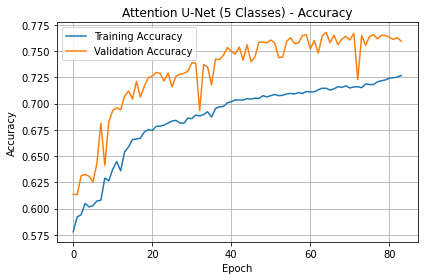

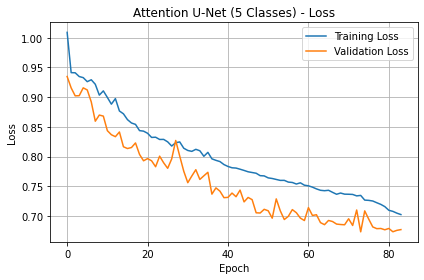


Training Summary:
  Best Training Accuracy: 0.7268
  Best Validation Accuracy: 0.7678
  Final Training Loss: 0.7025
  Final Validation Loss: 0.6771


: 

In [ ]:
# ============================================
# Plotting Accuracy and Loss - Load from saved history
# ============================================

# Load training history from file
history_dict = np.load('unet-attention-extra-5classes-history.npy', allow_pickle=True).item()

## Accuracy Plot
plt.figure(figsize=(6,4))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Attention U-Net (5 Classes) - Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/unet-attention-5classes-accuracy.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Loss Plot
plt.figure(figsize=(6,4))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Attention U-Net (5 Classes) - Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/unet-attention-5classes-loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\nTraining Summary:")
print(f"  Best Training Accuracy: {max(history_dict['accuracy']):.4f}")
print(f"  Best Validation Accuracy: {max(history_dict['val_accuracy']):.4f}")
print(f"  Final Training Loss: {history_dict['loss'][-1]:.4f}")
print(f"  Final Validation Loss: {history_dict['val_loss'][-1]:.4f}")

Loading model...
Computing confusion matrix incrementally...
  0/1602


2025-12-08 22:50:23.660494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-12-08 22:50:24.396072: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-12-08 22:50:24.396095: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-12-08 22:50:24.396169: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  800/1602
  1600/1602
  1602/1602 - Done!


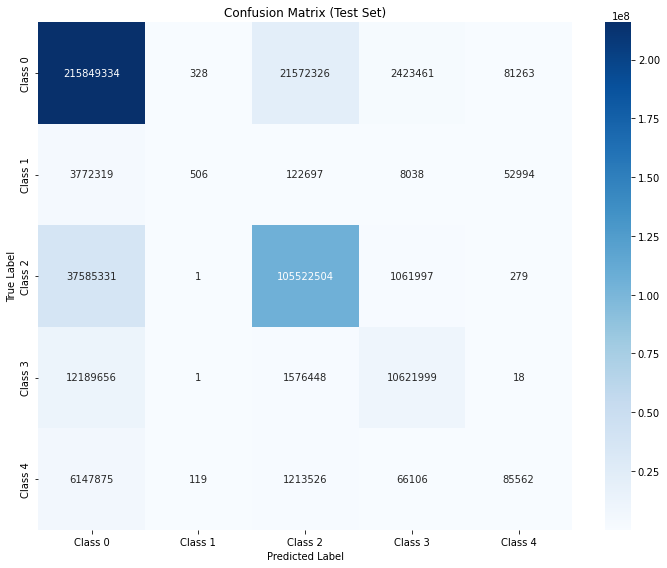


Confusion Matrix:
[[215849334       328  21572326   2423461     81263]
 [  3772319       506    122697      8038     52994]
 [ 37585331         1 105522504   1061997       279]
 [ 12189656         1   1576448  10621999        18]
 [  6147875       119   1213526     66106     85562]]

Confusion Matrix saved to: confusion_matrix_5classes.png


In [8]:
# ============================================
# Compute Confusion Matrix - Memory Optimized
# ============================================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import gc

# Load model if not already loaded
try:
    am_unet_extra_eval
except NameError:
    print("Loading model...")
    am_unet_extra_eval = UNetAM(
        trained_weights='unet-attention-extra-5classes.hdf5',
        input_size=(512, 512, 3),
        num_classes=5,
        filter_base=16,
        lr=0.0005
    )

# Initialize confusion matrix (5x5 for 5 classes)
cm = np.zeros((5, 5), dtype=np.int64)

print("Computing confusion matrix incrementally...")
BATCH_SIZE = 32  # Process multiple images at once

for batch_start in range(0, len(test_images_extra), BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(test_images_extra))
    
    if batch_start % 200 == 0:
        print(f"  {batch_start}/{len(test_images_extra)}")
    
    # Prepare batch
    batch_images = []
    batch_masks = []
    
    for i in range(batch_start, batch_end):
        batch_images.append(test_images_extra[i])
        batch_masks.append(test_masks_extra[i].flatten())
    
    # Stack into batch array
    batch_images = np.array(batch_images)  # (batch_size, 512, 512, 3)
    
    # Predict batch
    batch_preds = am_unet_extra_eval.predict(batch_images, verbose=0)
    batch_preds = np.argmax(batch_preds, axis=-1)  # (batch_size, 512, 512)
    
    # Update confusion matrix for each image in batch
    for pred, mask in zip(batch_preds, batch_masks):
        pred_flat = pred.flatten()
        cm += confusion_matrix(mask, pred_flat, labels=[0, 1, 2, 3, 4])
    
    # Clear memory
    del batch_images, batch_preds, batch_masks
    gc.collect()

print(f"  {len(test_images_extra)}/{len(test_images_extra)} - Done!")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_5classes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)
print("\nConfusion Matrix saved to: confusion_matrix_5classes.png")